In [92]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, TimeDistributed, Conv2D, MaxPooling2D

In [93]:
# Use GPU
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [94]:
np.random.seed(10)

path = "/content/drive/MyDrive/CISC499/CK+48"

dataDirectoryList = os.listdir(path)
imageDataList = []
labels = []
labelDictionary = {"anger":0, "contempt":1, "disgust":2, "fear":3, "happy":4, "sadness":5, "surprise":6}

In [95]:
for dataset in dataDirectoryList:
  imageList = os.listdir(path + "/" + dataset)
  print("Loaded the images of dataset-" + '{}\n'.format(dataset))
  for image in imageList:
    imagepath = path + "/" + dataset + "/" + image
    inputImage = cv2.imread(imagepath)
    inputImage = cv2.resize(inputImage, (48, 48))   # Resize images to 48x48
    imageDataList.append(inputImage)
    labels.append(labelDictionary[dataset])    # Label of each image is the name of its folder

Loaded the images of dataset-fear

Loaded the images of dataset-sadness

Loaded the images of dataset-anger

Loaded the images of dataset-disgust

Loaded the images of dataset-contempt

Loaded the images of dataset-happy

Loaded the images of dataset-surprise



In [96]:
lenSequence = 3
# Creates sequences of 3 images and adds them to a list.
newImageDataList = []
for i in range(0, len(imageDataList), lenSequence):
  newList = []
  image1 = imageDataList[i-3]
  image2 = imageDataList[i-2]
  image3 = imageDataList[i-1]
  newList.append(image1)
  newList.append(image2)
  newList.append(image3)
  newImageDataList.append(newList)
newImageData = np.array(newImageDataList).astype("float32") 
print(newImageData.shape)   # 327 sequences, 3 images per sequences, shape of image is 48x48x3.
newImageData /= 255    # Normalize images
numClasses = 7    # Labels of emotions

(327, 3, 48, 48, 3)


In [97]:
# Convert labels to one-hot encoding
oneHot = np_utils.to_categorical(labels, numClasses)
# Since the data is divided by 3 because they are now sequences, the labels should also be divided by 3.
# One sequence of 3 images should only have one label.
newOneHot = oneHot[0: len(oneHot): lenSequence]

# Split the dataset into training and testing
xTrain, xTest, yTrain, yTest = train_test_split(
    newImageData, newOneHot, test_size=0.15, random_state=10)
 
# Split validation data
xTrain, xValid, yTrain, yValid = train_test_split(
    xTrain, yTrain, test_size=0.15, random_state=10)

In [98]:
# Kernel size
# kernelSize = (2, 2)
# kernelSize = (3, 3)
kernelSize = (5, 5)
# kernelSize = (7, 7)

In [99]:
# Defining the model
model = Sequential()

# Convolutional layer.
model.add(TimeDistributed(Conv2D(32, kernel_size=kernelSize, activation="relu", padding="same"), input_shape=(lenSequence, 48, 48, 3)))
# Max pooling layer
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.2)))
print(model.output_shape)

# Convolutional layer.
model.add(TimeDistributed(Conv2D(64, kernel_size=kernelSize, activation="relu", padding="same")))
# Max pooling layer
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.2)))
print(model.output_shape)

# Convolutional layer.
model.add(TimeDistributed(Conv2D(128, kernel_size=kernelSize, activation="relu", padding="same")))
# Max pooling layer
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.2)))
print(model.output_shape)

# Flattens the features
# The output of this layer will now be: 3 timesteps, n features.
model.add(TimeDistributed(Flatten()))
model.add((Dropout(0.2)))
print(model.output_shape)

# LSTM layer
model.add(LSTM(50))   # activation function = tanh
print(model.output_shape)

# Output layer with softmax function
model.add(Dense(numClasses, activation="softmax"))

(None, 3, 24, 24, 32)
(None, 3, 12, 12, 64)
(None, 3, 6, 6, 128)
(None, 3, 4608)
(None, 50)


In [100]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [101]:
model_hist  = model.fit(xTrain, yTrain, batch_size=50, epochs=75, verbose=1, validation_data=(xValid, yValid))

Epoch 1/75
5/5 [==============================] - 2s 144ms/step - loss: 1.9212 - accuracy: 0.2090 - val_loss: 1.8803 - val_accuracy: 0.1667
Epoch 2/75
5/5 [==============================] - 0s 31ms/step - loss: 1.8439 - accuracy: 0.1841 - val_loss: 1.8546 - val_accuracy: 0.1667
Epoch 3/75
5/5 [==============================] - 0s 26ms/step - loss: 1.8144 - accuracy: 0.2442 - val_loss: 1.8271 - val_accuracy: 0.2619
Epoch 4/75
5/5 [==============================] - 0s 26ms/step - loss: 1.7967 - accuracy: 0.2969 - val_loss: 1.7787 - val_accuracy: 0.4286
Epoch 5/75
5/5 [==============================] - 0s 25ms/step - loss: 1.6843 - accuracy: 0.4724 - val_loss: 1.6941 - val_accuracy: 0.4286
Epoch 6/75
5/5 [==============================] - 0s 26ms/step - loss: 1.5732 - accuracy: 0.4405 - val_loss: 1.3403 - val_accuracy: 0.5952
Epoch 7/75
5/5 [==============================] - 0s 25ms/step - loss: 1.2463 - accuracy: 0.5814 - val_loss: 1.0077 - val_accuracy: 0.6429
Epoch 8/75
5/5 [==========

In [102]:
#Show the summary of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_70 (TimeDis (None, 3, 48, 48, 32)     2432      
_________________________________________________________________
time_distributed_71 (TimeDis (None, 3, 24, 24, 32)     0         
_________________________________________________________________
time_distributed_72 (TimeDis (None, 3, 24, 24, 32)     0         
_________________________________________________________________
time_distributed_73 (TimeDis (None, 3, 24, 24, 64)     51264     
_________________________________________________________________
time_distributed_74 (TimeDis (None, 3, 12, 12, 64)     0         
_________________________________________________________________
time_distributed_75 (TimeDis (None, 3, 12, 12, 64)     0         
_________________________________________________________________
time_distributed_76 (TimeDis (None, 3, 12, 12, 128)   

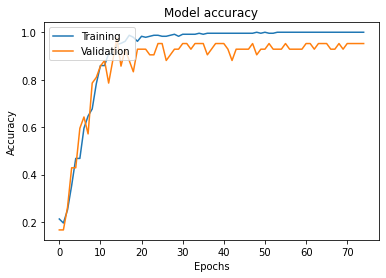

<Figure size 1440x720 with 0 Axes>

In [103]:
# Create plot of accuracy by epoch
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.figure(figsize=(20,10))
plt.show()

In [104]:
trainScore = model.evaluate(xTrain, yTrain, verbose=0)
print('Train loss:', trainScore[0])
print('Train accuracy:', 100*trainScore[1])

testScore = model.evaluate(xTest, yTest, verbose=0)
print('Test loss:', testScore[0])
print('Test accuracy:', 100*testScore[1])

Train loss: 0.004544800613075495
Train accuracy: 100.0
Test loss: 0.22571180760860443
Test accuracy: 98.00000190734863
